In [1]:
import numpy as np
import MSMRD as mrd
import MSMRD.integrators as integrators
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#define MSMmodel class to read in data
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters

In [3]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [4]:
model = pickle.load(open('../data/asym2D_lag100.p'))

In [5]:
print np.sum(model.tmatrix[:,-15:],axis=1)

[  2.95086895e-05   2.87292075e-04   7.17033613e-04   1.45258210e-04
   8.00859538e-04   2.41782194e-04   3.70360519e-04   3.68724129e-04
   7.00350008e-04   6.14710144e-02   6.00527124e-02   5.69846522e-02
   5.77265647e-02   6.35010810e-02   6.41667453e-02   5.61384912e-02
   5.48796104e-02   5.60654977e-02   6.17826312e-02   5.68306267e-02
   5.78807923e-02   5.99774910e-02   6.09972123e-02   6.33174876e-02
   3.60939482e-01   3.66606389e-01   3.64514221e-01   3.64404071e-01
   3.62791830e-01   3.67991256e-01   3.64810506e-01   3.58930705e-01
   3.58011751e-01   3.59462757e-01   3.60509612e-01   3.61186425e-01
   3.62968341e-01   3.63773731e-01   3.63033473e-01   8.47894675e-01
   8.46465682e-01   8.43782940e-01   8.48533813e-01   8.48018774e-01
   8.48939358e-01   8.47376572e-01   8.44943292e-01   8.46664180e-01
   8.45888011e-01   8.48111628e-01   8.44787478e-01   8.47146266e-01
   8.46093178e-01   8.49122642e-01]


In [7]:
T = np.copy(model.tmatrix)
for i in range(model.parameters['NCenters']):
    for j in range(model.parameters['NangularPartitions']):
        T[i,-j-1] = 0
for i in range(len(T)):
    T[i,:] /= np.sum(T[i,:])
print np.sum(T[:,-15:],axis=1)

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.06147101  0.06005271  0.05698465  0.05772656
  0.06350108  0.06416675  0.05613849  0.05487961  0.0560655   0.06178263
  0.05683063  0.05788079  0.05997749  0.06099721  0.06331749  0.36093948
  0.36660639  0.36451422  0.36440407  0.36279183  0.36799126  0.36481051
  0.3589307   0.35801175  0.35946276  0.36050961  0.36118643  0.36296834
  0.36377373  0.36303347  0.84789467  0.84646568  0.84378294  0.84853381
  0.84801877  0.84893936  0.84737657  0.84494329  0.84666418  0.84588801
  0.84811163  0.84478748  0.84714627  0.84609318  0.84912264]


In [8]:
msm = mrd.MSM(T, model.centers)

In [9]:
#overwrite exit states, now there is only 1 state from which the MSM can be exited
msm.exitStates = np.arange(model.parameters['NCenters'] + 2*model.parameters['NangularPartitions'], model.parameters['NCenters'] + 3*model.parameters['NangularPartitions'])

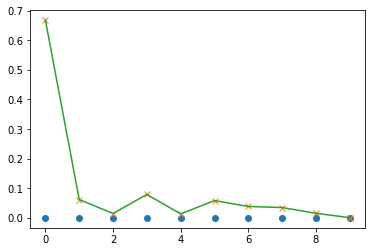

In [10]:
plt.plot((model.tmatrix - T)[0,:10], 'o')
plt.plot(model.tmatrix[0,:10], 'x')
plt.plot(T[0,:10])

In [11]:
#print just for checking
print msm.exitStates
print msm.entryStates

[39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
[0]


In [12]:
p = mrd.particle(np.array([-1.9, -1.9]), 1.)
integrator = integrators.MSMRDexitSampling(msm, 4.0, p, 0.1, model.parameters)

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   8.78159281e-03   5.33146070e-05   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.39764953e-06   4.42732572e-05   9.38294484e-03   4.36228627e-02
   4.88514472e-02   7.66329886e-05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.05691398e-04   5.00658068e-02   2.60443286e-01   1.00414865e-01
   4.34023451e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   6.05886724e-05
   1.00911252e-01   6.42798230e-01]
2.6


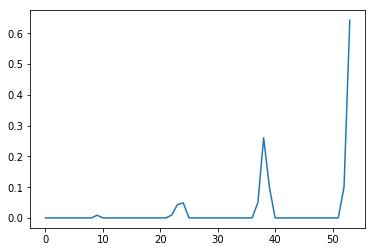

In [13]:
plt.plot(msm.T[:,-1])
print msm.T[:,-1]
print integrator.entryRadius

In [14]:
sim = mrd.simulation(integrator)
sim.run(1000000, sample=True)

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/MSMRD-0.1-py2.7.egg/MSMRD/simulation.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/MSMRD-0.1-py2.7.egg/MSMRD/MSM.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
print sim.traj

[[  0.00000000e+00  -1.99296094e+00  -1.71596527e+00  -1.00000000e+00]
 [  1.00000000e-01  -1.90447323e+00  -1.84115710e+00  -1.00000000e+00]
 [  2.00000000e-01   0.00000000e+00   0.00000000e+00   1.00000000e+01]
 ..., 
 [  9.99997000e+04   0.00000000e+00   0.00000000e+00   1.90000000e+01]
 [  9.99998000e+04   0.00000000e+00   0.00000000e+00   3.40000000e+01]
 [  9.99999000e+04  -1.74732939e+00  -2.99801750e+00  -1.00000000e+00]]


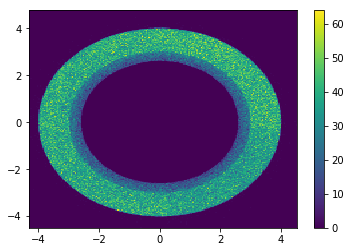

In [16]:
BDregion = np.where(sim.traj[:,3]==-1)[0]
obj = plt.hist2d(sim.traj[BDregion,1], sim.traj[BDregion,2], bins=200)
plt.colorbar()

In [17]:
class asym2DmilestoningMSMRD(object):
    def __init__(self, bathRadius, Ncenters):
        self.bathRadius = bathRadius
        self.Ncenters = Ncenters
        self.Nstates = Ncenters+1
    
    def getState(self, sample, prevstate):
        #check BD region first
        if sample[2] == -1:
            if np.linalg.norm(sample[:2]) > self.bathRadius:
                return self.Ncenters
            else:
                return prevstate
        else:
            if sample[2] < self.Ncenters:
                return sample[2]
            else:
                return prevstate
            
    def computeMilestoningTraj(self, traj):
        self.dTraj = np.zeros(len(traj))
        self.dTraj[0] = 0
        for i in range(1, len(traj)):
            self.dTraj[i] = self.getState(traj[i], self.dTraj[i-1])
            
    def computeMeanTransitionTimes(self, timestep):
        sumTau = np.zeros((self.Nstates, self.Nstates))
        counts = np.zeros((self.Nstates, self.Nstates))
        tau = 0
        for i in range(len(self.dTraj)):
            if self.dTraj[i] == self.dTraj[i-1]:
                tau += 1
            else:
                sumTau[self.dTraj[i-1], self.dTraj[i]] += tau
                counts[self.dTraj[i-1], self.dTraj[i]] += 1
                tau = 0
        nonzeros = np.where(counts!=0)[0]
        self.meanTransitionTimes = np.zeros_like(counts)
        for i in range(0, int(self.Nstates)):
            for j in range(0, int(self.Nstates)):
                if counts[i,j] != 0:
                    self.meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
        self.counts = counts

In [19]:
def computeMeanTransitionTimes(timestep, mobj):
    sumTau = np.zeros((mobj.Nstates, mobj.Nstates))
    counts = np.zeros((mobj.Nstates, mobj.Nstates))
    for dTraj in [mobj.dTraj]:
        i = 1
        tau = 1
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        while i<len(dTraj)-1:
            i += 1
            if dTraj[i] == dTraj[i-1]:
                tau += 1
            else:
                if not np.in1d(dTraj[i], statesVisited):
                    sumTau[transitionFrom, dTraj[i]] += tau
                    counts[transitionFrom, dTraj[i]] += 1
                    if nextTransitionIndex < 0:
                        nextTransitionIndex = i
                    statesVisited.append(dTraj[i])
                    tau +=1
                else:
                    transitionFrom = dTraj[nextTransitionIndex]
                    statesVisited = [transitionFrom]
                    i = nextTransitionIndex
                    nextTransitionIndex = -1
                    tau = 1
    meanTransitionTimes = np.zeros((mobj.Nstates, mobj.Nstates))
    for i in range(0, mobj.Nstates):
        for j in range(0, mobj.Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [20]:
milestoning = asym2DmilestoningMSMRD(3.0, 9)
milestoning.computeMilestoningTraj(sim.traj[:,1:4])

In [21]:
milestoning.computeMeanTransitionTimes(0.1)

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
MTT = computeMeanTransitionTimes(0.1, milestoning)

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


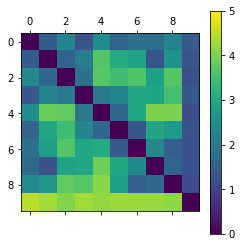

In [23]:
plt.matshow(MTT)
plt.colorbar()
plt.clim((0., 5.0))

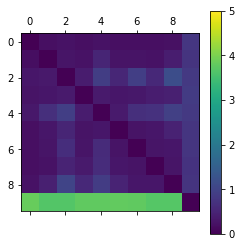

In [29]:
plt.matshow(milestoning.meanTransitionTimes)
plt.colorbar()
plt.clim((0., 5.0))

In [24]:
import pickle
BDtransitionTimes = pickle.load(open('2DasymMTT_longTraj.p'))

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


nan

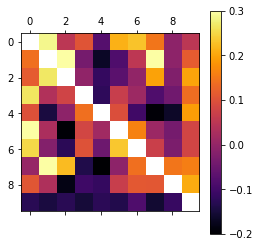

In [29]:
diff = (MTT - BDtransitionTimes)/BDtransitionTimes
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(diff)

In [56]:
print milestoning.counts[2][6]

15.0


In [49]:
msm.T[2,6]

0.00021044323847520596

In [20]:
#compute milestoning trajectory
#1 corresponds to the unbound, 0 to the bound state
b = np.zeros(len(sim.traj))
boundStates = np.where(np.linalg.norm(model.centers, axis=1) <= 1.0)[0]
for i in range(len(sim.traj)):
    if sim.traj[i, 3] == -1:
        if np.linalg.norm(sim.traj[i,1:3]) >= 3.0:
            b[i] = 1
        else:
            b[i] = b[i-1]
    else:
        if np.in1d(sim.traj[i,3], boundStates):
            b[i] = 0
        else:
            b[i] = b[i-1]

In [21]:
print np.sum(b)/len(b)

0.7962722


In [25]:
transitions = b[1:]-b[:-1]
AtoB = np.where(transitions == 1)[0]
BtoA = np.where(transitions == -1)[0]
def transitionTimes(AtoB, BtoA):
    if len(AtoB) == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case1"
            tauBtoA = BtoA - AtoB
            tauAtoB = AtoB[1:] - BtoA[:-1]
        else:
            print "case2"
            tauAtoB = AtoB - BtoA
            tauBtoA = BtoA[1:] - AtoB[:-1]
    elif len(AtoB)+1 == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case3"
            tauBtoA = BtoA[:-1] - AtoB
            tauAtoB = AtoB[1:] - BtoA[:-2]
        else:
            print "case4"
            tauAtoB = AtoB - BtoA[:-1]
            tauBtoA = BtoA[1:] - AtoB
    elif len(AtoB)-1 == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case5"
            tauBtoA = BtoA - AtoB[:-1]
            tauAtoB = AtoB[1:] - BtoA
        else:
            print "case6"
            tauAtoB = AtoB[:-1] - BtoA
            tauBtoA = BtoA[1:-1] - AtoB[:-2]
    else:
        return None
    return tauAtoB, tauBtoA
tauAtoB, tauBtoA = transitionTimes(AtoB, BtoA)

case2


In [27]:
timestep = 0.05
print "mean tauBtoA", np.mean(timestep*tauBtoA)
print "mean tauAtoB", np.mean(timestep*tauAtoB)
print "std tauBtoA", np.std(timestep*tauBtoA)
print "std tauAtoB", np.std(timestep*tauAtoB)
print "mean stationary distribution", np.sum(b)/len(b)

mean tauBtoA 6.8667661314
mean tauAtoB 1.75694056366
std tauBtoA 6.40886492939
std tauAtoB 1.3277413142
mean stationary distribution 0.7962722


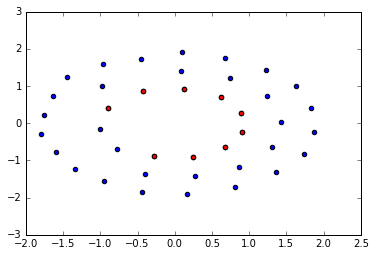

In [28]:
plt.scatter(model.centers[:,0], model.centers[:,1])
boundStates = np.where(np.linalg.norm(model.centers, axis=1) <= 1.0)[0]
plt.scatter(model.centers[boundStates,0], model.centers[boundStates,1], c='r')

In [46]:
print boundStates

[ 1  2  3  8  9 13 15 18 22]


In [69]:
print (len(np.where(np.logical_and(sim.traj[:,3]==-1, np.linalg.norm(sim.traj[:,1:3], axis=1)<3.0))[0])+len(np.where(sim.traj[:,3]!=-1)[0]))/float(len(sim.traj))

0.885895
